In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt

import res.fnn.training as training
import res.fnn.functions as func
from res.fnn.generator import Generator
from res.fnn.discriminator import Discriminator

import res.process_data.process_raw_data as prd
import res.process_data.dire_and_coor as dc
import res.process_data.process_output as out
from res.process_data.dataset import tensor_dataset

In [2]:
# prepare the raw data
# .. mean previous layer
coordinates_input = prd.read_coordinate(16, '../../data/Coordinates.dat')
directions_input = dc.coor_direction_four(coordinates_input)
one_hot_vector = dc.one_hot_four(directions_input)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
z_dim = 8
lr = 0.0001
device

'cpu'

In [4]:
# define the generator and discriminator
gen = Generator(z_dim, im_dim=60, hidden_dim=16).to(device)
disc = Discriminator(im_dim=60, hidden_dim=16).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr = lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr = lr)

In [5]:
# build the dataset
shuffle = True
batch_size = 128
num_worker = 1
pin_memory = True

input_tensor = torch.Tensor(one_hot_vector)
my_dataset = tensor_dataset(input_tensor, 15, 4)
my_dataloader = DataLoader(dataset= my_dataset,
                            shuffle=shuffle,
                            batch_size=batch_size,
                            num_workers=num_worker,
                            pin_memory=pin_memory)

In [6]:
n_epochs = 10
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True
gen_loss = False
error = False
display_step = 500

In [7]:
disc_loss_list, gen_loss_list = training.training_bce(gen, disc, z_dim, n_epochs, my_dataloader,
                                         device, disc_opt, gen_opt, cur_step, display_step,
                                         mean_discriminator_loss,mean_generator_loss)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 0, step 500: Generator loss: 0.7738391631841671, discriminator loss: 0.6504560532569885


  0%|          | 0/782 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [15]:
# save the model
# torch.save({'state_dict': gen.state_dict()}, 'gen_one_hot.pth.tar')

In [21]:
# load the model
model = Generator(z_dim, im_dim=60, hidden_dim=16).to(device)
checkpoint = torch.load('gen_one_hot.pth.tar')
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [22]:
print (model)

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=8, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=128, out_features=60, bias=True)
    (5): Tanh()
  )
)


In [23]:
noise = func.get_noise(16, 8)
len(noise)

16

In [24]:
# get output data, convert one hot vector to direction, convert direction to coordinates
coordinate_output = np.zeros([16000, 16 ,2])
for i in range(1000):
    noise = func.get_noise(16, 8)
    output = model(noise).data.numpy()
    for j in range(16):
        one_hot_matrix = out.slicing_output(output[j], "onehot")
        direction = out.one_hot_to_direction_four(one_hot_matrix)
        coordinate = out.four_direction_to_coordinates(direction)
        coordinate_output[(i * 16) + j] = coordinate

In [24]:
len(coordinate_output)

16000

In [25]:
# plot some polymer
# for i in range(10):
#     out.plot_polymer(coordinate_output[i])

In [26]:
folding_count, crossing_count, self_avoid = out.count_fold_cross(coordinate_output)

In [27]:
print (folding_count, crossing_count, self_avoid)
print (folding_count/16000, crossing_count/16000, self_avoid/16000)

2421 4431 10398
0.1513125 0.2769375 0.649875


In [28]:
# get the n to n distance and mse
distance_array = np.zeros(16000)
for i in range(16000):
    distance_array[i]= out.n_n_distance(coordinate_output[i])

<AxesSubplot:ylabel='Count'>

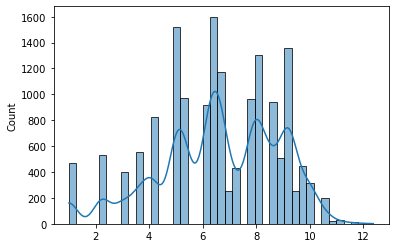

In [29]:
sns.histplot(data=distance_array, kde=True)

<AxesSubplot:ylabel='Count'>

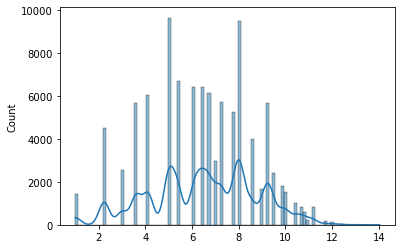

In [30]:
input_distance_array = np.zeros(100000)
for i in range(100000):
    input_distance_array[i] = out.n_n_distance(coordinates_input[i])
sns.histplot(data=input_distance_array, kde=True)

In [31]:
def statistics(n2n_distance_array):
    """
    calculate some
    """
    mean = np.mean(n2n_distance_array)
    std = np.std(n2n_distance_array)
    mse = np.mean((n2n_distance_array - mean) ** 2)
    return mean, std, mse

In [32]:
statistics(input_distance_array)

(6.499296237636025, 2.262412079054168, 5.118508415450203)

In [33]:
statistics(distance_array)

(6.6030638283307015, 2.2486213729729343, 5.056298078990684)

In [ ]:
print ("done")